<a href="https://colab.research.google.com/github/Mario-RJunior/diagnostico-medico-raio-x/blob/main/departamento_medico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Departamento médico

## Importação das bibliotecas e base de dados

In [1]:
# Importado as bibliotecas
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Acessando os arquivos pelo Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Criando o caminho até as imagens
xray_directory = '/content/drive/My Drive/Departamento médico/Dataset/'

In [4]:
# Verificando a presença das imagens no caminho acima
os.listdir(xray_directory)

['.DS_Store', '0', '2', '1', '3']

In [5]:
# Acessando as imagens
image_generator = ImageDataGenerator(rescale=1./225)

In [6]:
# Buscando as imagens de treinamento
train_generator = image_generator.flow_from_directory(batch_size=40,
                                                      directory=xray_directory,
                                                      shuffle=True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='training')

Found 532 images belonging to 4 classes.


In [7]:
# Variáveis para teste
train_images, train_labels = next(train_generator)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [9]:
# Mostrando cada uma das classes
train_labels

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]],

Note que temos 4 classes e portanto nossa rede neural terá 4 neurônios na camada de saída.

In [10]:
# Identificando os labels (funciona como variável dummy)
label_names = {0: 'Covid-19', 1: 'Normais', 2: 'Pneumonia viral', 3: 'Pneumonia bacterial'}

## Visualização dos dados

Queremos inicialmente listar as imagens carrgando-as diretamente do Google Colab.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

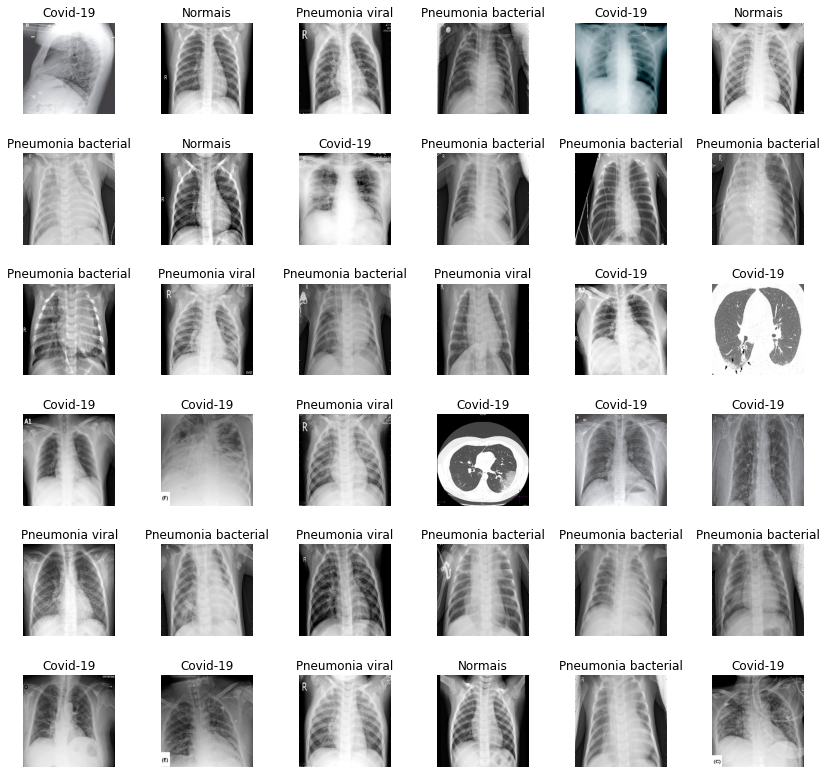

In [11]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(14,14))
axes = axes.ravel()  # Transforma uma matriz em um vetor

for i in np.arange(0,36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Carregamento da rede neural com pesos pré-treinados

In [12]:
# Criando um modelo base
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_tensor=Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 3s 0us/step


Fizemos então o carregamento do modelo base que usaremos para treinar nossas imagens relacionadas às doenças pulmonares. Veremos então as camadas do modelo.

In [13]:
# Camadas do base model
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Este resultado acima mostra a arquitetura da ResNet que já está totalmente definida.

In [14]:
# Verificando a quantidade de camadas
len(base_model.layers)

175

Como iremos utilizar uma rede neural ja previamente treinada, precisamos aproveitar os pesos já obtidos por ela para usá-los no nosso modelo. Para isso, faremos o seguinte código:

In [15]:
# Congelando os pesos (exceto das 10 últimas camadas)
for layer in base_model.layers[:-10]:
  layers.treinable = False # "Congela" os pesos para estes não serem treinados novamente

## Construção e treinamento do modelo de Deep Learning

De posse do modelo base construido na seção anterior, iremos aplicá-lo agora no nosso modelo.

In [16]:
# Criando o cabeçalho da nossa rede neural
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation='softmax')(head_model)

In [18]:
# Criando o modelo
model = Model(inputs=base_model.input, outputs=head_model)

In [24]:
# Compilando a rede neural
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4, 
                                           decay=1e-6), 
              metrics=['accuracy'])

In [29]:
# Fazendo o treinamento da rede neural
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

Precisamos ainda redefinir a variável train_generator para batch_size = 4. Isto faz com que o ajuste dos pesos seja feito de 4 em 4 imagens.

In [30]:
# Redefinindo a variável train_generator
train_generator = image_generator.flow_from_directory(batch_size=4,
                                                      directory=xray_directory,
                                                      shuffle=True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='training')

Found 532 images belonging to 4 classes.


In [31]:
# Histórico do treinamento
history = model.fit_generator(train_generator, epochs=25, callbacks=[checkpointer])

Epoch 1/25
133/133 [==============================] - 409s 3s/step - loss: 0.6880 - accuracy: 0.7594
Epoch 2/25
133/133 [==============================] - 406s 3s/step - loss: 0.5035 - accuracy: 0.8346
Epoch 3/25
133/133 [==============================] - 407s 3s/step - loss: 0.3625 - accuracy: 0.8816
Epoch 4/25
133/133 [==============================] - 406s 3s/step - loss: 0.2636 - accuracy: 0.9117
Epoch 5/25
133/133 [==============================] - 407s 3s/step - loss: 0.1957 - accuracy: 0.9342
Epoch 6/25
133/133 [==============================] - 407s 3s/step - loss: 0.1494 - accuracy: 0.9605
Epoch 7/25
133/133 [==============================] - 404s 3s/step - loss: 0.1154 - accuracy: 0.9586
Epoch 8/25
133/133 [==============================] - 410s 3s/step - loss: 0.1228 - accuracy: 0.9718
Epoch 9/25
133/133 [==============================] - 408s 3s/step - loss: 0.0450 - accuracy: 0.9868
Epoch 10/25
133/133 [==============================] - 407s 3s/step - loss: 0.0669 - accura

## Avaliação da rede neural

Feito o treinamento da rede neural iremos agora avaliar sua performance.

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

Plotando um gráfico do Accuracy, que é a taxa de acerto e do loss que é o erro do modelo na base de treinamento.

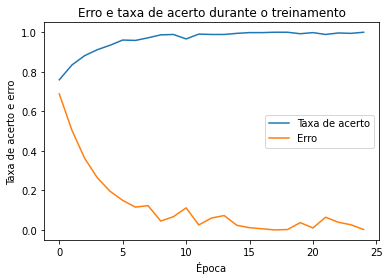

In [33]:
# Plotando o accuracy e o loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);